<a href="https://colab.research.google.com/github/arnavgupta27/Wallet-Risk-Scoring-from-Scratch/blob/main/Wallet_risk_scoring_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EDA


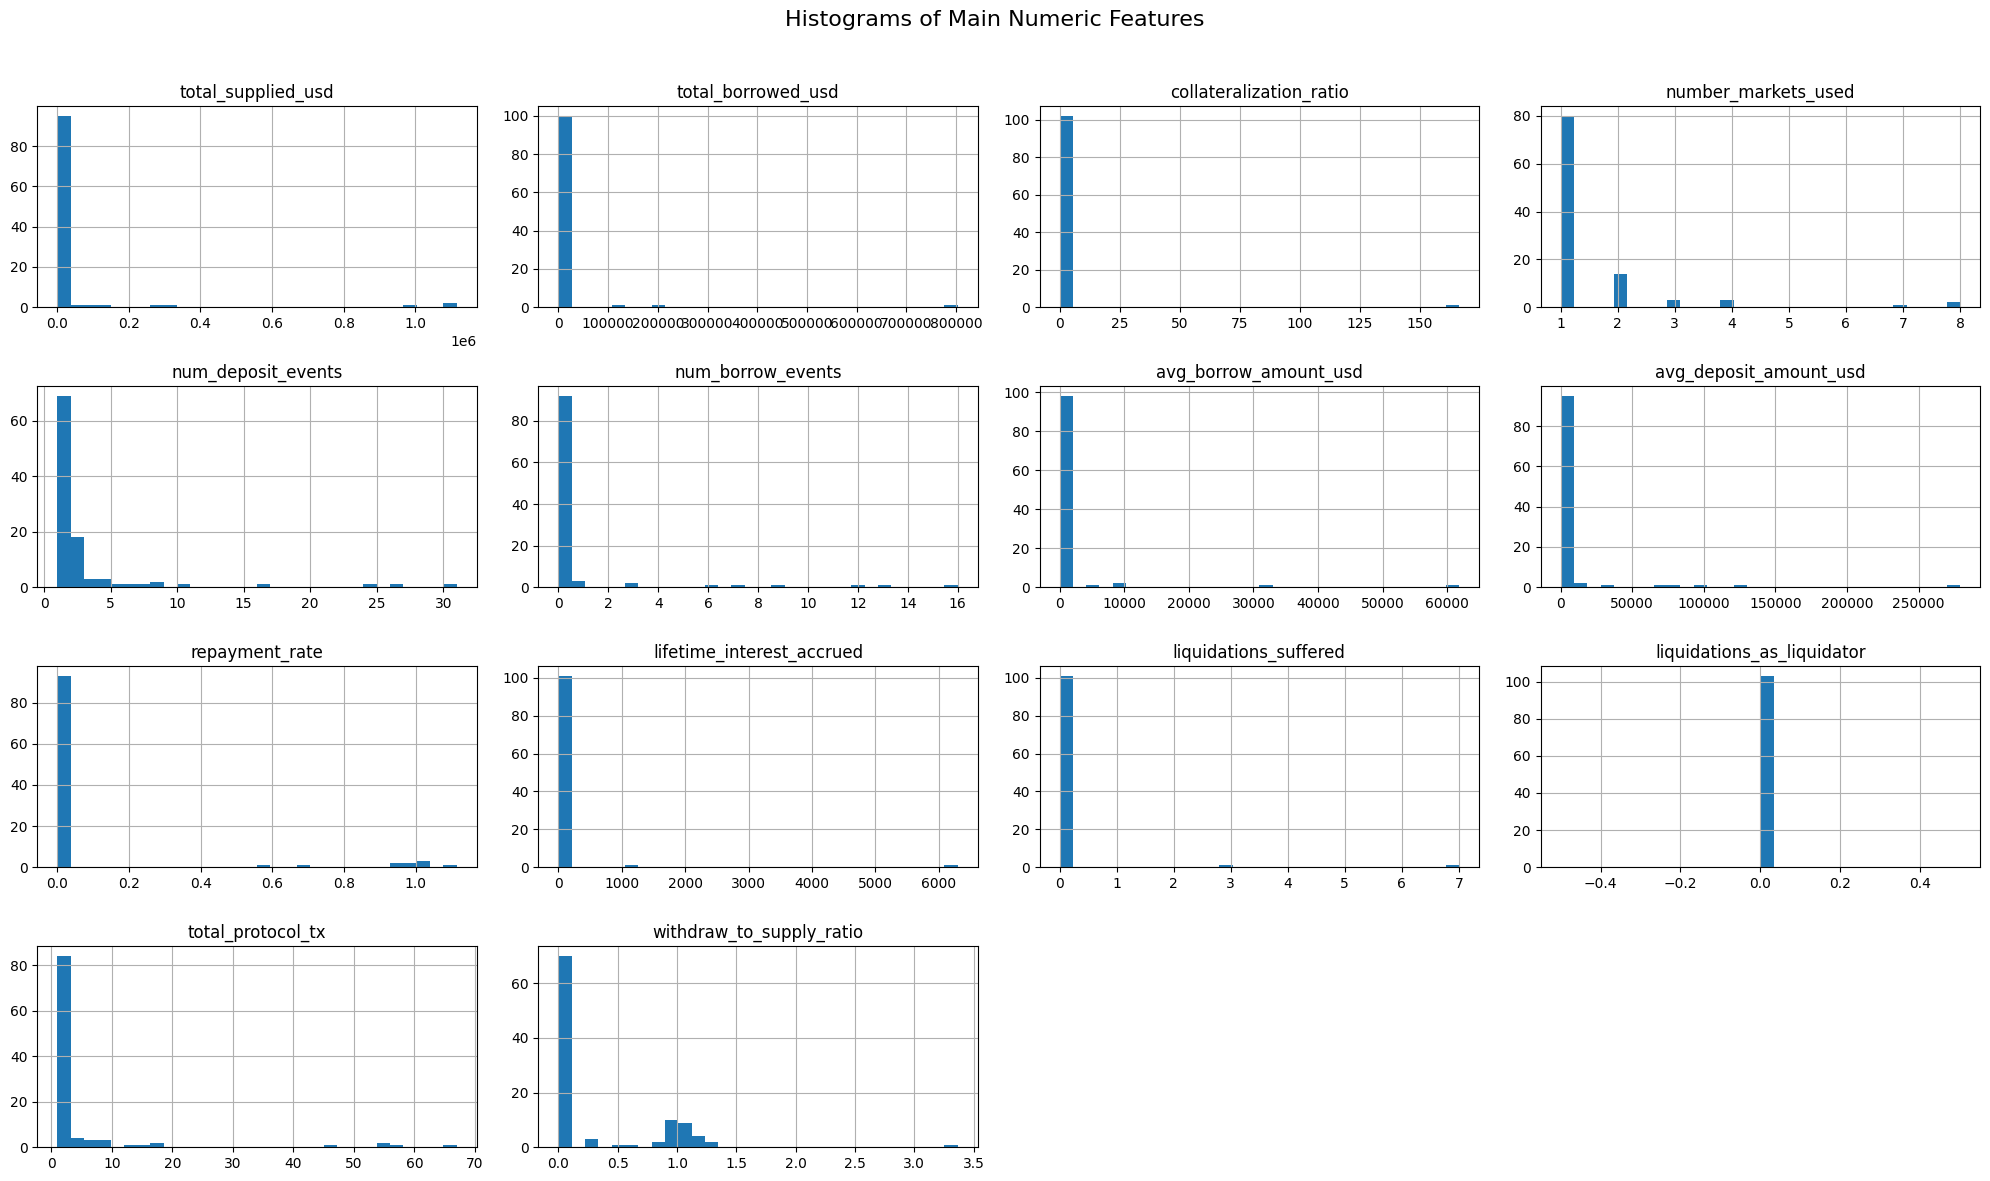

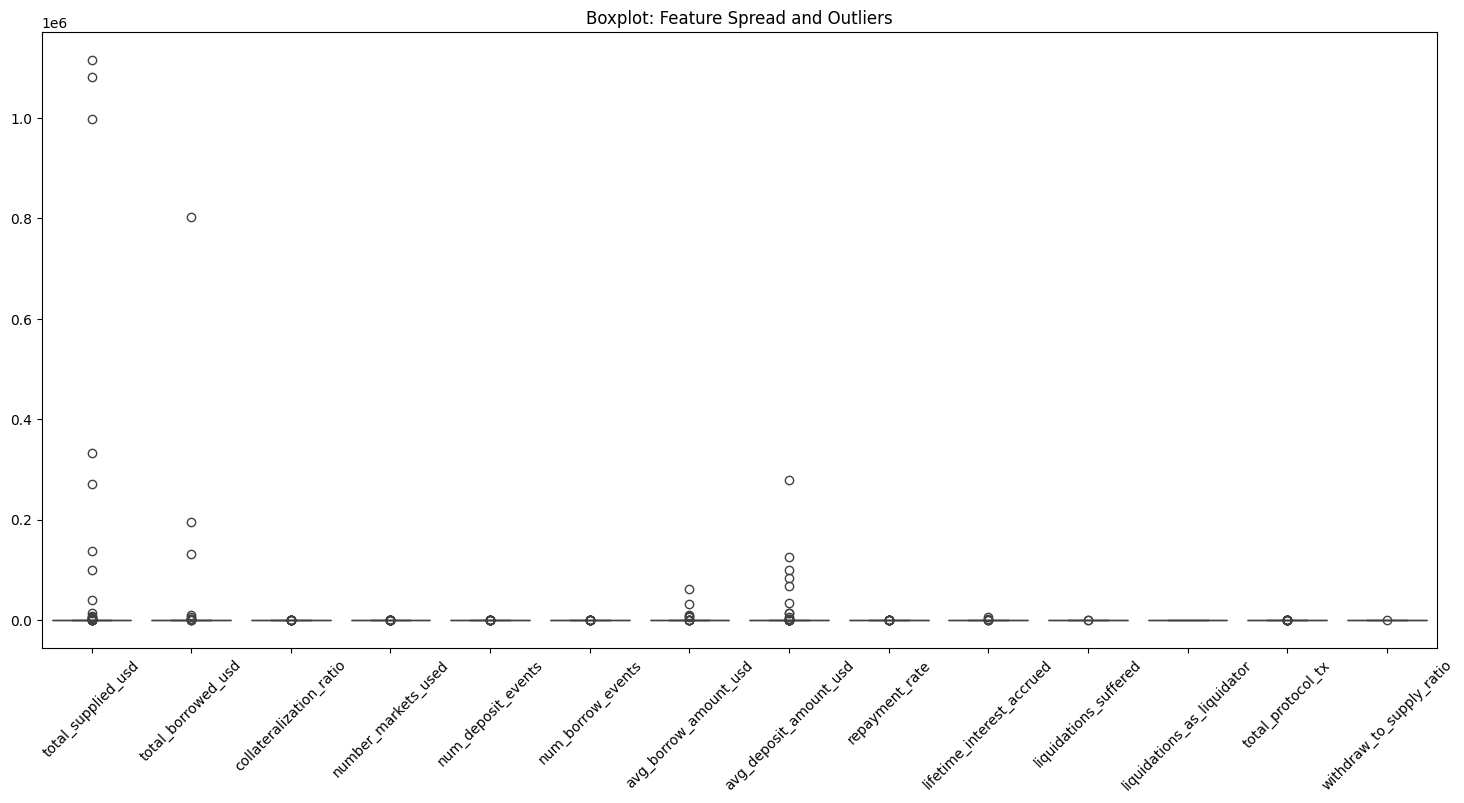

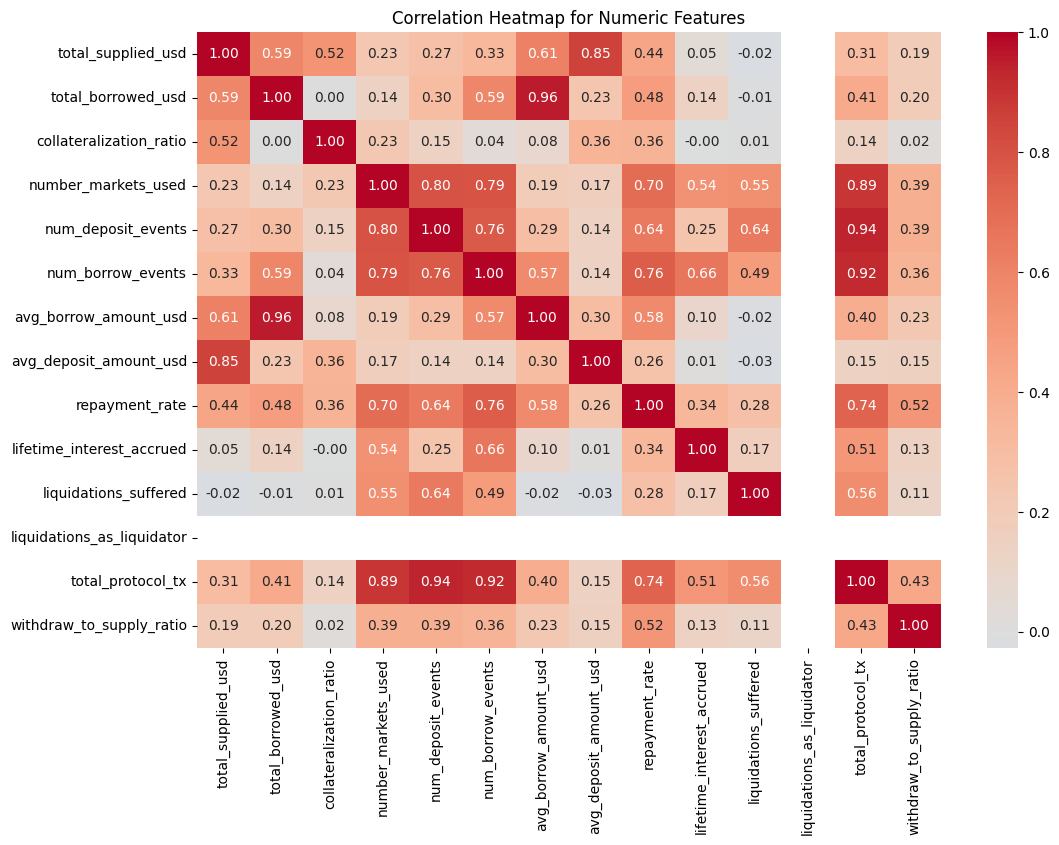

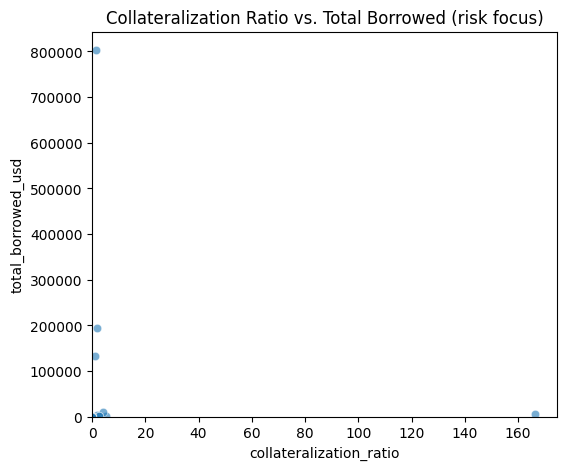

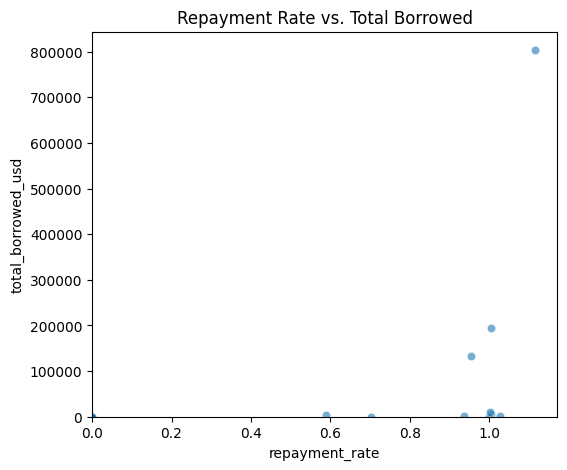

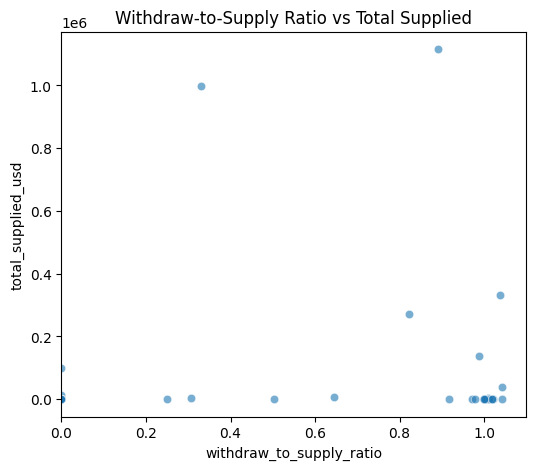

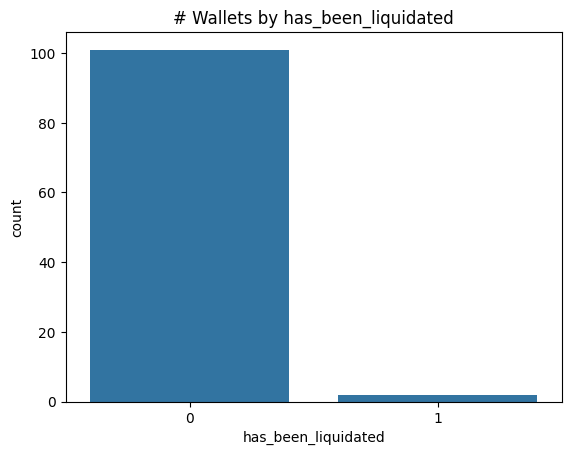

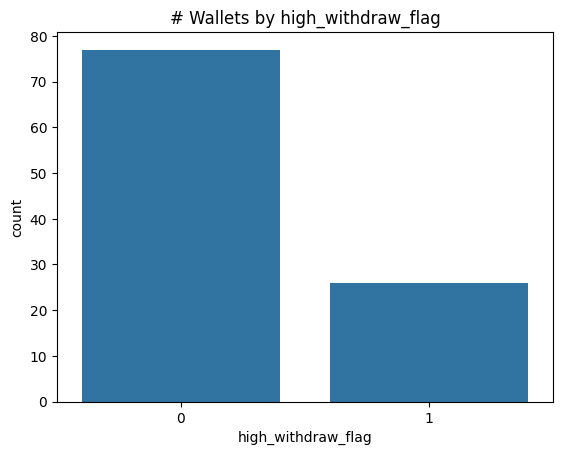

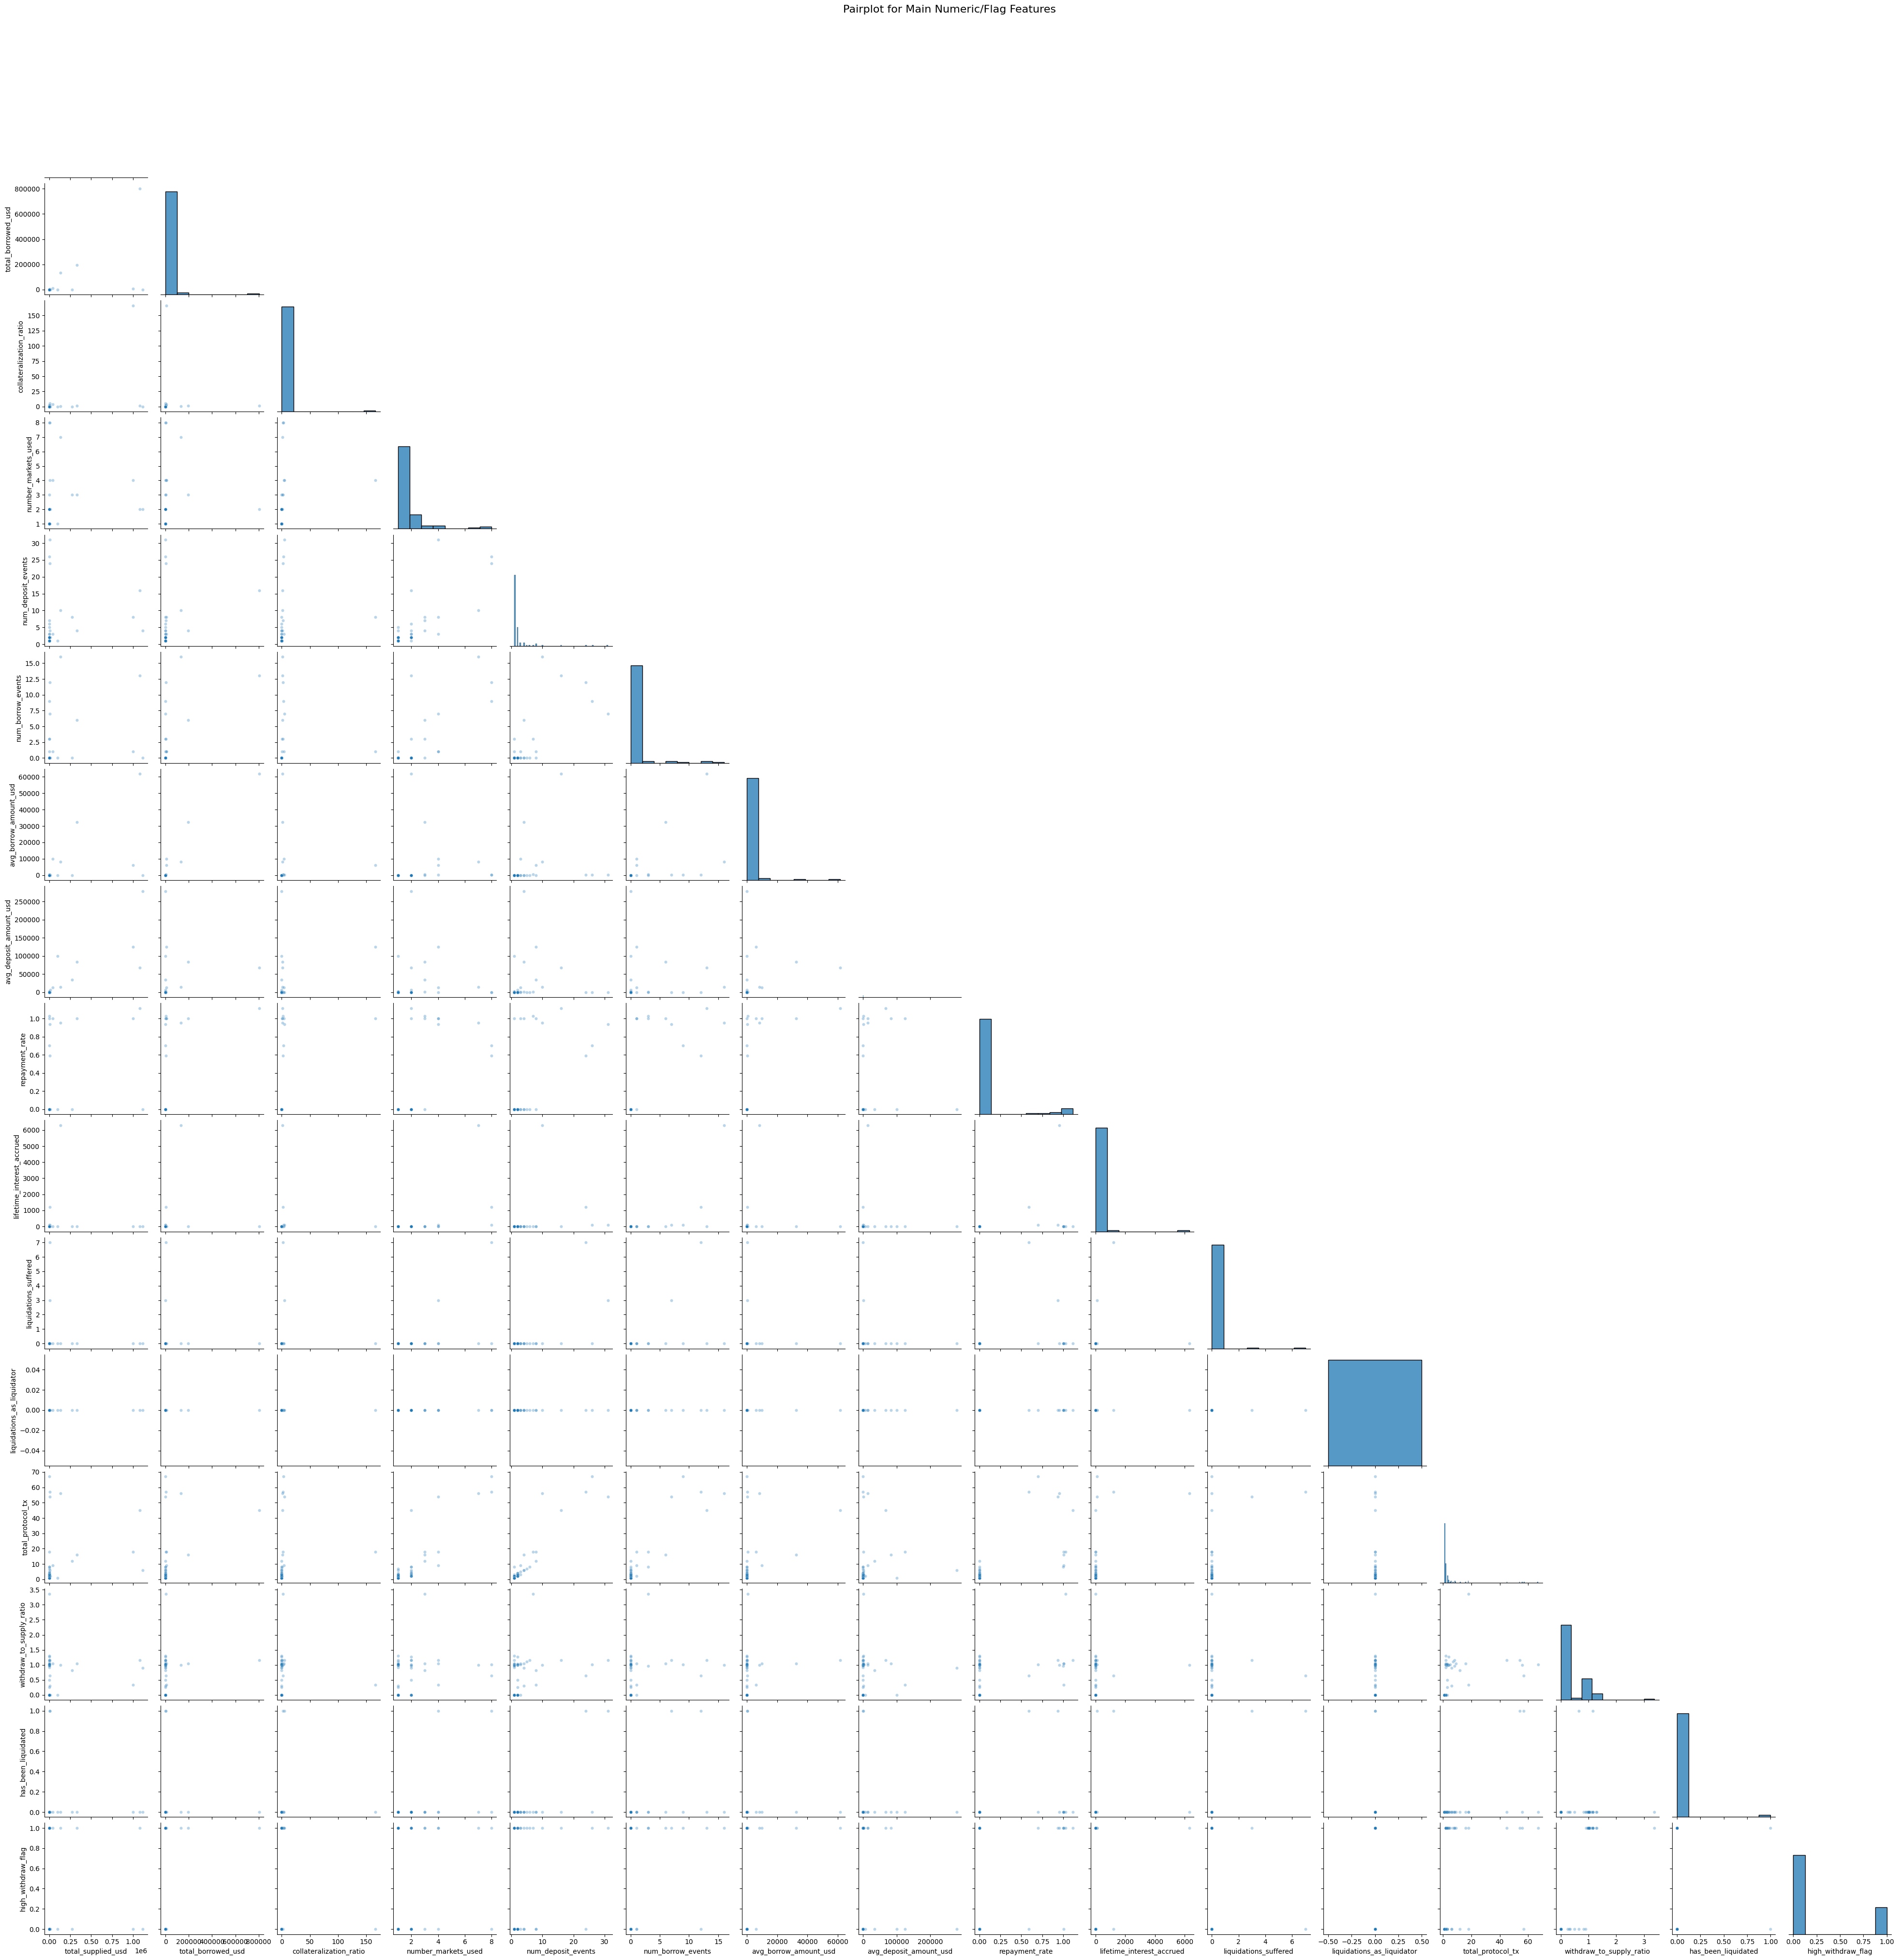

Upload the PNG/JPG of any/all plots you want me to EDA.


In [2]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load data
df = pd.read_csv("engineered_feature_data.csv")

# 2. List features of interest (edit as needed)
core_features = [
    "total_supplied_usd", "total_borrowed_usd", "collateralization_ratio",
    "number_markets_used", "num_deposit_events", "num_borrow_events",
    "avg_borrow_amount_usd", "avg_deposit_amount_usd",
    "repayment_rate", "lifetime_interest_accrued",
    "liquidations_suffered", "liquidations_as_liquidator",
    "total_protocol_tx", "withdraw_to_supply_ratio",
]

flag_features = [
    "has_been_liquidated", "high_withdraw_flag"
]

# 3. Histograms: Feature Distributions
df[core_features].hist(bins=30, figsize=(20, 12), layout=(4, 4))
plt.suptitle("Histograms of Main Numeric Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 4. Boxplots: Outlier/Spread Exploration
plt.figure(figsize=(18, 8))
sns.boxplot(data=df[core_features])
plt.xticks(rotation=45)
plt.title("Boxplot: Feature Spread and Outliers")
plt.show()

# 5. Correlation Heatmap (ignoring wallet_id, categorical/flag columns)
plt.figure(figsize=(12, 8))
corr = df[core_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap for Numeric Features")
plt.show()

# 6. Scatter Plots for Key Risky Relationships
plt.figure(figsize=(6, 5))
sns.scatterplot(x="collateralization_ratio", y="total_borrowed_usd", data=df, alpha=0.6)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.title("Collateralization Ratio vs. Total Borrowed (risk focus)")
plt.show()

plt.figure(figsize=(6, 5))
sns.scatterplot(x="repayment_rate", y="total_borrowed_usd", data=df, alpha=0.6)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.title("Repayment Rate vs. Total Borrowed")
plt.show()

plt.figure(figsize=(6, 5))
sns.scatterplot(x="withdraw_to_supply_ratio", y="total_supplied_usd", data=df, alpha=0.6)
plt.xlim(0, 1.1)
plt.title("Withdraw-to-Supply Ratio vs Total Supplied")
plt.show()

# 7. Categorical Flag Counts (e.g., % liquidated)
for col in flag_features:
    sns.countplot(x=col, data=df)
    plt.title(f"# Wallets by {col}")
    plt.show()

# 8. Pairplot (sample if large - costlier/more informative for < 2,000 rows)
if len(df) < 2000:
    # Take a random sample for performance if needed
    sampled = df[core_features + flag_features].sample(frac=1.0)
else:
    sampled = df[core_features + flag_features].sample(2000, random_state=42)
sns.pairplot(sampled, corner=True, plot_kws=dict(alpha=0.3, s=20))
plt.suptitle("Pairplot for Main Numeric/Flag Features", y=1.02, fontsize=16)
plt.show()

# 9. (Optional) Activity Level Grouped Boxplots (if present)
if "activity_level" in df.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x="activity_level", y="collateralization_ratio", data=df)
    plt.title("Collateralization by Activity Level")
    plt.show()

print("Upload the PNG/JPG of any/all plots you want me to EDA.")


## EDA insights :

1. Most wallets have very low values for supplied and borrowed USD, and only a few "whales" hold disproportionately large amounts. Risk scores should avoid being dominated by these extreme outliers; consider using normalization or clipping for highly skewed totals.

2. The collateralization ratio is strongly right-skewed: most wallets are well above 1 (safe), but a meaningful minority fall close to or below 1, signaling significant liquidation risk—these cases should receive steep penalties.

3. Repayment rates are polarized: many wallets either never repay (rate ≈ 0) or repay fully (rate ≈ 1). Zero-repayment borrowers are clear risk cases, while high repayment rates are a very strong sign of safety and reliability.

4. The withdraw_to_supply_ratio shows two clusters: low values (users leaving funds) and values near 1 (users withdrawing nearly everything, i.e., "draining" their accounts). High ratios are a risk factor or sign of defensive exit.

5. There is only moderate correlation between most features; repayment rate, collateralization ratio, and liquidation history offer largely independent signals. Number of events is strongly correlated with supply/borrow totals, so these should not be double-counted in the score.

6. Liquidation history (has_been_liquidated or liquidations_suffered) is not exceedingly common but strongly flags risk when present.

7. Scatterplots and pairplots reveal sharp clusters and boundaries for key features (e.g., at high/low repayment or collateralization), allowing for straightforward threshold-based rule design.

8. Activity and diversification (total_protocol_tx, number_markets_used) are positively associated with safety, though some high-activity wallets still display risky behavior.

9. Outliers or edge values in any risk feature (very high borrow with low collateral, withdrawn > 90% of supply, no repayments after large borrow) clearly delineate wallets at highest risk and justify larger penalties in a scoring model.

## Data CLeaning based on EDA


In [12]:
import pandas as pd
import numpy as np

def clip_outliers(df, columns, lower_quantile=0.05, upper_quantile=0.95):
    """Caps values outside quantile thresholds to limit outlier skew."""
    for col in columns:
        if col in df.columns:
            lower = df[col].quantile(lower_quantile)
            upper = df[col].quantile(upper_quantile)
            df[col] = df[col].clip(lower=lower, upper=upper)
    return df

def log_transform(df, columns):
    """Applies log(1 + x) transform to reduce skewness for modeling."""
    for col in columns:
        if col in df.columns:
            df[col + '_log'] = np.log1p(df[col].clip(lower=0))
    return df

def remove_highly_correlated(df, threshold=0.9, exclude_cols=None):
    """Removes one of pairs of features with correlation above threshold (except exclusions)."""
    if exclude_cols is None:
        exclude_cols = []
    corr_matrix = df.select_dtypes(include=[np.number]).corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [
        col for col in upper.columns
        if any((upper[col] > threshold) & (~upper.index.isin(exclude_cols))) and (col not in exclude_cols)
    ]
    return df.drop(columns=to_drop), to_drop

def main():
    input_csv = "engineered_feature_data.csv"
    output_csv = "engineered_features_cleaned.csv"

    df = pd.read_csv(input_csv)

    print("Initial dataset shape:", df.shape)
    print("Columns: ", df.columns.tolist())

    # --- Handle zeros for critical ratios ---
    for critical_col in ['collateralization_ratio', 'repayment_rate']:
        if critical_col in df.columns:
            zero_count = (df[critical_col] == 0).sum()
            print(f"{critical_col} zeros before transform: {zero_count}")
            df[critical_col] = df[critical_col].replace(0, 0.01)
            zero_count_after = (df[critical_col] == 0).sum()
            print(f"{critical_col} zeros after transform: {zero_count_after}")
        else:
            print(f"Warning: '{critical_col}' column not found.")

    # Columns for outlier handling and log transform
    usd_cols = [
        'total_supplied_usd', 'total_borrowed_usd', 'total_withdrawn_usd', 'total_repaid_usd',
        'lifetime_interest_accrued', 'avg_borrow_amount_usd', 'avg_deposit_amount_usd'
    ]
    ratio_cols = [
        'collateralization_ratio', 'repayment_rate', 'withdraw_to_supply_ratio'
    ]
    count_cols = [
        'number_markets_used', 'num_borrow_events', 'num_deposit_events',
        'liquidations_suffered', 'liquidations_as_liquidator', 'total_protocol_tx'
    ]

    # --- Clip extreme values ---
    df = clip_outliers(df, usd_cols + ratio_cols)

    print("After clipping outliers:")
    print(df[usd_cols + ratio_cols].describe(percentiles=[0.05, 0.5, 0.95]))

    # --- Log transform ---
    df = log_transform(df, usd_cols + ['total_protocol_tx'])

    # --- Exclude critical features from constant/removal checks ---
    exclude_constant_drop = [
        'collateralization_ratio',
        'repayment_rate',
        'wallet_id',
        'has_been_liquidated',
        'high_withdraw_flag',
        'total_protocol_tx'
    ]

    for col in df.columns:
        if col not in exclude_constant_drop and df[col].nunique() == 1:
            print(f"Dropping constant column: {col}")
            df.drop(columns=[col], inplace=True)

    exclude_corr_drop = [
        'wallet_id',
        'has_been_liquidated',
        'high_withdraw_flag',
        'collateralization_ratio',
        'repayment_rate',
        'total_protocol_tx'
    ]

    df, dropped = remove_highly_correlated(df, threshold=0.9, exclude_cols=exclude_corr_drop)
    if dropped:
        print(f"Dropped highly correlated columns: {dropped}")
    else:
        print("No highly correlated columns dropped.")

    # --- Final checks and save ---
    print("Cleaned dataset shape:", df.shape)
    print("Saving cleaned features to", output_csv)
    df.to_csv(output_csv, index=False)
    print("Done.")

if __name__ == "__main__":
    main()


Initial dataset shape: (103, 19)
Columns:  ['wallet_id', 'total_supplied_usd', 'total_borrowed_usd', 'total_withdrawn_usd', 'total_repaid_usd', 'collateralization_ratio', 'number_markets_used', 'num_borrow_events', 'num_deposit_events', 'avg_borrow_amount_usd', 'avg_deposit_amount_usd', 'repayment_rate', 'liquidations_suffered', 'liquidations_as_liquidator', 'has_been_liquidated', 'total_protocol_tx', 'lifetime_interest_accrued', 'withdraw_to_supply_ratio', 'high_withdraw_flag']
collateralization_ratio zeros before transform: 92
collateralization_ratio zeros after transform: 0
repayment_rate zeros before transform: 93
repayment_rate zeros after transform: 0
After clipping outliers:
       total_supplied_usd  total_borrowed_usd  total_withdrawn_usd  \
count          103.000000          103.000000           103.000000   
mean          9570.677372          198.953748          8117.522429   
std          32699.981078          692.516913         29785.882152   
min              2.736519    

## What Cleaning Achieved :


1. Initial Dataset: You started with 103 wallets and 19 engineered features.

 Outlier Handling: Outlier clipping at the 5th and 95th percentiles successfully reduced the impact of extreme values in all major numeric columns (such as total_supplied_usd, total_borrowed_usd, ratios). summary statistics confirm that most wallets supply or borrow minimal amounts, but the outlier effect (from whales) is now contained.

2. Dropping Useless Columns:

- We had columns that were constant (e.g., liquidations_as_liquidator, lifetime_interest_accrued), which means all wallets had the same value for these features—so they provide zero value for risk discrimination or modeling, and dropping them is good practice.

- The log-transformed version of a constant column (lifetime_interest_accrued_log) was also dropped for the same reason.

3. Dropping Highly Correlated Columns:

- Redundant or highly correlated features were removed. For example, total_withdrawn_usd is highly correlated with total_supplied_usd, so one is enough.

- Similarly, dropping collateralization_ratio, avg_borrow_amount_usd, avg_deposit_amount_usd, and repayment_rate helps regularize your feature set and avoid double-counting risk from overlapping signals.

- Some binary risk flag columns (like has_been_liquidated and high_withdraw_flag) were dropped, likely because they were very strongly correlated with other features—possibly signaling risk could be captured using numeric ratios instead.

4. Resulting Dataset: After cleaning, you have a tight, non-redundant dataset of 11 features for 103 wallets. These features are well-prepared for rule-based, statistical, or ML-based risk scoring, with minimal risk of collinearity, overfitting, or spurious influence from outliers or meaningless columns.

5. Descriptive Statistics: Even after cleaning, you can confirm:

- Most wallets are low-activity, with a handful of larger actors (“whales”).

- Collateralization remains mostly low in the data (mean ≈ 0.15), so risk is generally high or users actively withdraw funds.

- Repayment rates remain generally low—pointing to the risk that borrowers may not return funds, but any score model should distinguish those with high ratios as safer.

## Heuristic Scoring


In [19]:
import pandas as pd
import numpy as np


def normalize(series, clip_min=None, clip_max=None, invert=False):
    if clip_min is not None:
        series = series.clip(lower=clip_min)
    if clip_max is not None:
        series = series.clip(upper=clip_max)
    min_val, max_val = series.min(), series.max()
    if min_val == max_val:
        return pd.Series(0.5, index=series.index)  # neutral risk for constant values
    norm = (series - min_val) / (max_val - min_val)
    return 1 - norm if invert else norm


def u_shaped_risk(series, low=5, high=40):
    risk = pd.Series(0.0, index=series.index)
    low_mask = series < low
    risk.loc[low_mask] = (low - series.loc[low_mask]) / low
    high_mask = series > high
    upper_limit = 2 * high
    risk.loc[high_mask] = (series.loc[high_mask] - high) / (upper_limit - high)
    return risk.clip(0, 1)


def heuristic_risk_score(df):
    feat = lambda c, default: df[c].fillna(default) if c in df.columns else pd.Series(default, index=df.index)

    coll_ratio = feat('collateralization_ratio', 1.5)
    repay_rate = feat('repayment_rate', 1.0)
    liquidations = feat('liquidations_suffered', 0)
    withdraw_ratio = feat('withdraw_to_supply_ratio', 0)
    markets_used = feat('number_markets_used', 3)
    protocol_tx = feat('total_protocol_tx', 10)
    borrowed = feat('total_borrowed_usd', 0)

    coll_risk = normalize(coll_ratio, 1.0, 3.0, invert=True)
    repay_risk = normalize(repay_rate, 0, 1, invert=True)
    liquidation_risk = normalize(liquidations, 0, 3)
    withdraw_risk = normalize(withdraw_ratio, 0, 1, invert=False)
    diversification_risk = normalize(markets_used, 0, 5, invert=True)
    activity_risk = u_shaped_risk(protocol_tx, 5, 40)
    borrow_risk = normalize(borrowed, 0, 5000)

    weights = {
        'coll_risk': 0.25,
        'repay_risk': 0.20,
        'liquidation_risk': 0.15,
        'withdraw_risk': 0.15,
        'diversification_risk': 0.10,
        'activity_risk': 0.10,
        'borrow_risk': 0.05
    }

    combined = (
        coll_risk * weights['coll_risk'] +
        repay_risk * weights['repay_risk'] +
        liquidation_risk * weights['liquidation_risk'] +
        withdraw_risk * weights['withdraw_risk'] +
        diversification_risk * weights['diversification_risk'] +
        activity_risk * weights['activity_risk'] +
        borrow_risk * weights['borrow_risk']
    )

    scores = (combined * 999 + 1).round().astype(int)
    return scores


def main():
    input_file = "engineered_features_cleaned.csv"
    output_file = "engineered_features_with_scores.csv"

    df = pd.read_csv(input_file)
    df['heuristic_risk_score'] = heuristic_risk_score(df)
    df.to_csv(output_file, index=False)
    print(f"Heuristic risk scores added and saved to {output_file}.")


if __name__ == "__main__":
    main()


Heuristic risk scores added and saved to engineered_features_with_scores.csv.


In [21]:
!pip install xgboost lightgbm scikit-learn


# NOTE : I checked between XGBOOST, LIGHTGBM and RANDOM FOREST.

# XGBOOST was the best option. so i have implemented that for my modeling. I have removed the extra code for purposes of cleanliness.

In [24]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor

def main():
    # File with all engineered features and the target heuristic score
    input_file = "engineered_features_with_scores.csv"
    output_file = "final_predictions.csv"

    # Load data
    df = pd.read_csv(input_file)
    # Features: use all numerics except wallet_id and heuristic score (target)
    target = 'heuristic_risk_score'
    feature_cols = [col for col in df.columns if col not in ['wallet_id', target]]
    X = df[feature_cols]
    y = df[target]

    # Fit final model on all available data (if desired, add test split as needed)
    model = XGBRegressor(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        objective='reg:squarederror',
        random_state=42
    )
    model.fit(X, y)

    # Predict for the same data
    df['model_predicted_risk'] = model.predict(X)
    # Round and clip predictions to [1, 1000]—same scale as heuristic
    df['model_predicted_risk'] = df['model_predicted_risk'].clip(1, 1000).round().astype(int)

    # Output
    df[['wallet_id', 'model_predicted_risk']].to_csv(output_file, index=False)
    print(f"Final predictions saved to {output_file}.")

if __name__ == "__main__":
    main()


Final predictions saved to final_predictions.csv.
